# Imports

### Libraries

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as dates_
import seaborn as sns
from pyowm.owm import OWM
from pyowm.utils import timestamps, formatting
from datetime import datetime, timedelta, timezone, date
import matplotlib.dates as mdates
from pathlib import Path

### Data

##### Picking the right day

In [2]:
day = 4
month = 12
year = 2021
offset = (datetime.now() - datetime(year, month, day)).days
root_path = 'data/Daily Full/' + '0' + str(day) + '.' + str(month) + '.' + str(year)

##### Split dataframes into dictionaries by day

In [3]:
def df_by_day(df, date_col_name="start_time"):
    # Get all available days
    days = df[date_col_name].dt.to_period("D").unique()

    #create a DataFrame dictionary to store your data frames
    df_by_day = {elem : pd.DataFrame for elem in days}

    for key in df_by_day.keys():
        df_by_day[key] = df[:][df[date_col_name].dt.to_period("D") == key]
    
    return df_by_day, days

##### Heart Beat Data

In [4]:
# Find all json files
samsung_base_dir = os.path.join('data', 'Samsung Data', '04.12.2021')

json_file_names = []
for file in os.listdir(os.path.join(samsung_base_dir, 'jsons', 'com.samsung.health.heart_rate')):
    if file != '.ipynb_checkpoints':
        json_file_names.append(file)

df_json_readings = []
print(len(json_file_names))
for i in range(len(json_file_names)):
    file_name = json_file_names[i]
    df = pd.read_json(os.path.join(samsung_base_dir,'jsons', 'com.samsung.health.heart_rate', file_name))
    df_json_readings.append(df.copy())

df_heart_rate_json = pd.concat(df_json_readings, axis=0, ignore_index=True)
df_heart_rate_json = df_heart_rate_json.sort_values(by=['start_time'], ascending=True, ignore_index=True)

37


###### Create dictionnary with data per day

In [5]:
HR_by_day, HR_day_keys = df_by_day(df_heart_rate_json)

In [6]:
HR_by_day[HR_day_keys[3]]

,heart_rate,heart_rate_max,heart_rate_min,start_time,end_time
1693,113,128,100,2021-12-04 00:00:00,2021-12-04 00:00:59
1694,101,107,95,2021-12-04 00:01:00,2021-12-04 00:01:59
1695,99,107,87,2021-12-04 00:02:00,2021-12-04 00:02:59
1696,98,99,98,2021-12-04 00:03:00,2021-12-04 00:03:59
1697,77,82,74,2021-12-04 00:06:00,2021-12-04 00:06:59
...,...,...,...,...,...
1941,85,89,82,2021-12-04 04:35:00,2021-12-04 04:35:59
1942,85,89,83,2021-12-04 04:36:00,2021-12-04 04:36:59
1943,85,87,84,2021-12-04 04:37:00,2021-12-04 04:37:59
1944,83,88,81,2021-12-04 04:38:00,2021-12-04 04:38:59


##### Calendar Data

In [7]:
# Load CSV file
cal_base_dir = os.path.join('data', 'Calendar Data')
df_calendar = pd.read_csv(os.path.join('data', 'Calendar Data', '05.12.2021.csv'), sep='\t')

# Rename columns with simpler names
df_calendar = df_calendar.rename(columns={'Given planned earliest start' : 'start_time', 'Given planned earliest end' : 'end_time'})
df_calendar = df_calendar.drop(['Notes', 'Assigned Resources', 'Additional Title'], axis=1)

# Convert date columns into date format
df_calendar['start_time'] = pd.to_datetime(df_calendar['start_time'], dayfirst=False)
df_calendar['end_time'] = pd.to_datetime(df_calendar['end_time'], dayfirst=False)

# Sort Dataframe by date
df_calendar = df_calendar.sort_values(by=['start_time'], ascending=True, ignore_index=True)

In [8]:
cal_by_day, cal_day_keys = df_by_day(df_calendar)

##### Weather Data
We can go back up to 5 days ago, but unfortunately not more than that.

In [9]:
APIKEY = '12c406b33039d61c116a70eefb3526bb' #your API Key here as string
OpenWMap = OWM(APIKEY) # Use API key to get data
mgr = OpenWMap.weather_manager()
lausanne_lat = 46.5196535
lausanne_lon = 6.6322734


# Query 'offset' days ago data
nb_of_days = offset
offset_days_ago_epoch = int((datetime.now() - timedelta(days=nb_of_days)).replace(tzinfo=timezone.utc).timestamp())
one_call_offset_days_ago = mgr.one_call_history(lat=52.5244, lon=13.4105, dt=offset_days_ago_epoch)
weather_offset_days_ago = one_call_offset_days_ago.forecast_hourly

In [10]:
# Iterate over each hour of the day
for i in range(len(weather_offset_days_ago)):
    print(weather_offset_days_ago[i].detailed_status)
    print(weather_offset_days_ago[i].temperature('celsius'))

light snow
{'temp': 1.19, 'feels_like': -3.85}
light snow
{'temp': 1.45, 'feels_like': -3.73}
light rain
{'temp': 1.45, 'feels_like': -3.93}
light rain
{'temp': 0.94, 'feels_like': -3.29}
overcast clouds
{'temp': 1.01, 'feels_like': -2.93}
light intensity drizzle
{'temp': 1.71, 'feels_like': -2.2}
light snow
{'temp': 1.64, 'feels_like': -1.98}
light snow
{'temp': 1.56, 'feels_like': -2.66}
broken clouds
{'temp': 1.68, 'feels_like': -1.93}
broken clouds
{'temp': 1.68, 'feels_like': -1.93}
overcast clouds
{'temp': 1.44, 'feels_like': -1.74}
broken clouds
{'temp': 2.21, 'feels_like': -1.86}
broken clouds
{'temp': 2.33, 'feels_like': -1.71}
broken clouds
{'temp': 2.62, 'feels_like': -0.46}
overcast clouds
{'temp': 2.49, 'feels_like': -0.61}
overcast clouds
{'temp': 2.3, 'feels_like': -1.18}
overcast clouds
{'temp': 2.17, 'feels_like': -1.63}
overcast clouds
{'temp': 1.87, 'feels_like': -1.7}
broken clouds
{'temp': 1.76, 'feels_like': -2.67}
broken clouds
{'temp': 1.84, 'feels_like': -2.04}

##### Step Count Data

In [11]:
# Find all json files
samsung_base_dir = os.path.join('data', 'Samsung Data', '04.12.2021')

# Finding step count file
filename = ''
for file in os.listdir(samsung_base_dir):
    if file.startswith('com.samsung.health.step_count'):
        filename = file


# Importing data
cols_names = ["speed", "pkg_name", "count", "sample_position_type", "time_offset", "start_time", "calorie", 
              "deviceuuid", "custom", "end_time", "datauuid", "distance", "create_time", "update_time"]
df_step_count = pd.read_csv(os.path.join(samsung_base_dir, filename), skiprows=1,names=cols_names)

# Cleaning dataset
cols_to_drop = ["pkg_name", "sample_position_type", "time_offset", "deviceuuid", "custom", "datauuid", "create_time", "update_time"]
df_step_count = df_step_count[1:]
df_step_count = df_step_count.drop(cols_to_drop, axis=1)

# Convert date columns into date format
df_step_count['start_time'] = df_step_count['start_time'].replace('à', 'at', regex=True)
df_step_count['end_time'] = df_step_count['end_time'].replace('à', 'at', regex=True)

df_step_count['start_time'] = pd.to_datetime(df_step_count['start_time'], dayfirst=True)
df_step_count['end_time'] = pd.to_datetime(df_step_count['end_time'], dayfirst=True)

# Convert count into int
df_step_count['count'] = df_step_count['count'].apply(lambda count: int(count))

# Sort Dataframe by date
df_step_count = df_step_count.sort_values(by=['start_time'], ascending=True, ignore_index=True)

In [12]:
step_by_day, step_day_keys = df_by_day(df_step_count)

In [13]:
step_by_day[step_day_keys[0]]

,speed,count,start_time,calorie,end_time,distance
0,1.388889,16,2021-11-28 13:50:00,0.570000,2021-11-28 13:50:59,11.510000
1,1.497405,22,2021-11-28 13:51:00,0.730000,2021-11-28 13:51:59,17.090000
2,1.277778,17,2021-11-28 13:56:00,0.590000,2021-11-28 13:56:59,12.440000
3,2.027778,19,2021-11-28 14:06:00,0.660000,2021-11-28 14:06:59,15.370000
4,1.277778,15,2021-11-28 14:11:00,0.520000,2021-11-28 14:11:59,11.120000
5,1.527778,59,2021-11-28 14:12:00,2.050000,2021-11-28 14:12:59,45.690000
6,1.764286,14,2021-11-28 14:12:00,0.457786,2021-11-28 14:13:00,12.350000
7,0.403583,20,2021-11-28 14:45:00,1.058468,2021-11-28 14:46:00,13.360000
8,1.388889,12,2021-11-28 14:45:00,0.400000,2021-11-28 14:45:59,9.020000
9,1.555556,33,2021-11-28 17:05:00,1.140000,2021-11-28 17:05:59,25.200000


# Use-case : 1 day ago (04.12.2021)
As this is merely an example, we will look at it during a day, but the analysis can easily be repeated fro a week, or larger period.

##### Get key for day we want

In [14]:
def get_key(day, month, year):
    for key in cal_day_keys:
        if key.start_time.day == day and key.start_time.month == month and key.start_time.year == year:
            cal_key = key
    return cal_key

In [15]:
#day = 3
#month = 12
#year = 2021

day_key = get_key(day, month, year)

##### Filter calendar data to keep only data for a day

In [16]:
df_filtered_dates = cal_by_day[day_key]
# Create mask for bars in plotting
df_filtered_dates['plot_dummies'] = np.ones(len(df_filtered_dates)).astype(int)*df_heart_rate_json['heart_rate_max'].max()
#df_filtered_dates.at[893,'Title']= "Repas avec Flo à Morges" 

df_filtered_dates['bar_width'] = df_filtered_dates['end_time'] - df_filtered_dates['start_time']
df_filtered_dates['bar_width'] = df_filtered_dates['bar_width'].apply(lambda t : t.seconds//3600 * 0.0415)

In [17]:
df_filtered_dates.head()

,Title,start_time,end_time,plot_dummies,bar_width
924,Unimail avec Jessie,2021-12-04 09:00:00,2021-12-04 18:00:00,167,0.3735


In [18]:
df_filtered_dates.to_csv('data/Daily Full/03.12.2021/calendar.csv', index=False)

##### Prepare weather data for plotting

In [19]:
# Weather data
actual_temp = []
feels_like_temp = []
weather = []

for i in range(len(weather_offset_days_ago)):
    actual_temp.append(weather_offset_days_ago[i].temperature('celsius')['temp'])
    feels_like_temp.append(weather_offset_days_ago[i].temperature('celsius')['feels_like'])
    weather.append(weather_offset_days_ago[i].detailed_status)

In [20]:
data_range = pd.date_range(start=datetime(year, month, day, 0, 0, 0), periods=24, freq="60 min")

# Create datafram
weather_data = [actual_temp, feels_like_temp, weather]
df_weather = pd.DataFrame(np.vstack(weather_data))
df_weather = df_weather.T
df_weather = df_weather.rename(columns={0:'actual_temp', 1:'feels_like_temp', 2: 'weather'})
df_weather['time'] = data_range

df_weather['actual_temp'] = df_weather['actual_temp'].astype(float)
df_weather['feels_like_temp'] = df_weather['feels_like_temp'].astype(float)

In [21]:
df_weather.head(50)

,actual_temp,feels_like_temp,weather,time
0,1.19,-3.85,light snow,2021-12-04 00:00:00
1,1.45,-3.73,light snow,2021-12-04 01:00:00
2,1.45,-3.93,light rain,2021-12-04 02:00:00
3,0.94,-3.29,light rain,2021-12-04 03:00:00
4,1.01,-2.93,overcast clouds,2021-12-04 04:00:00
5,1.71,-2.20,light intensity drizzle,2021-12-04 05:00:00
6,1.64,-1.98,light snow,2021-12-04 06:00:00
7,1.56,-2.66,light snow,2021-12-04 07:00:00
8,1.68,-1.93,broken clouds,2021-12-04 08:00:00
9,1.68,-1.93,broken clouds,2021-12-04 09:00:00


##### Change day (cheating on day of heart rate measurement)

In [22]:
df_HR = HR_by_day[day_key]

In [23]:
df_HR.head(10000)

,heart_rate,heart_rate_max,heart_rate_min,start_time,end_time
1693,113,128,100,2021-12-04 00:00:00,2021-12-04 00:00:59
1694,101,107,95,2021-12-04 00:01:00,2021-12-04 00:01:59
1695,99,107,87,2021-12-04 00:02:00,2021-12-04 00:02:59
1696,98,99,98,2021-12-04 00:03:00,2021-12-04 00:03:59
1697,77,82,74,2021-12-04 00:06:00,2021-12-04 00:06:59
...,...,...,...,...,...
1941,85,89,82,2021-12-04 04:35:00,2021-12-04 04:35:59
1942,85,89,83,2021-12-04 04:36:00,2021-12-04 04:36:59
1943,85,87,84,2021-12-04 04:37:00,2021-12-04 04:37:59
1944,83,88,81,2021-12-04 04:38:00,2021-12-04 04:38:59


##### Prepare step count data

In [24]:
df_step_by_day = step_by_day[day_key]

In [25]:
df_step_by_day.head(1000)

,speed,count,start_time,calorie,end_time,distance
1342,1.861111,15,2021-12-04 00:16:00,0.520000,2021-12-04 00:16:59,12.790000
1343,1.611111,46,2021-12-04 00:17:00,1.530000,2021-12-04 00:17:59,35.930000
1344,0.907001,33,2021-12-04 00:17:00,1.162461,2021-12-04 00:18:00,22.590000
1345,0.320834,20,2021-12-04 00:19:00,1.469271,2021-12-04 00:20:00,16.200001
1346,0.412903,8,2021-12-04 00:26:00,0.485665,2021-12-04 00:27:00,6.400000
...,...,...,...,...,...,...
1580,0.212846,7,2021-12-04 21:40:00,0.698647,2021-12-04 21:41:00,5.820000
1581,0.777444,33,2021-12-04 22:22:00,1.592110,2021-12-04 22:23:00,28.444450
1582,0.761809,4,2021-12-04 22:23:00,0.174868,2021-12-04 22:24:00,3.635549
1583,0.567879,16,2021-12-04 23:25:00,0.636045,2021-12-04 23:26:00,10.000000


# Plotting all together

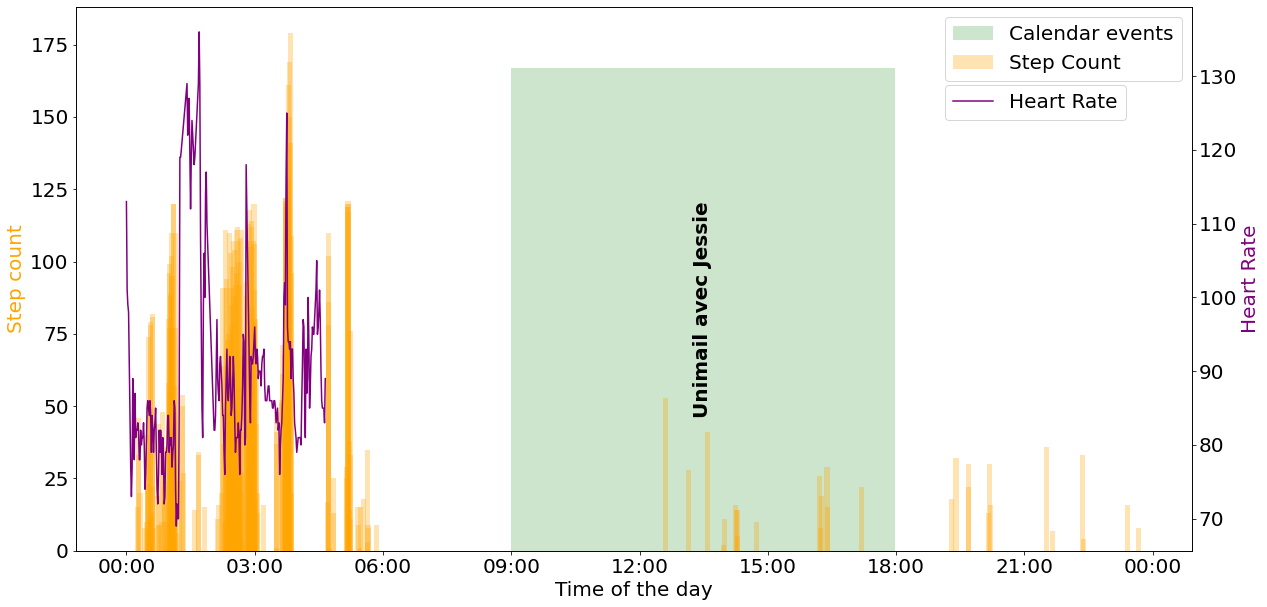

In [26]:
# BASIC PLOT STUFF
fig, ax = plt.subplots(figsize=(20, 10))
ax2=ax.twinx()

############# FIRST LAYER #################
# CALENDAR
cal = ax.bar(df_filtered_dates['start_time'],
        df_filtered_dates['plot_dummies'],
        color='green', width=df_filtered_dates['bar_width'], alpha=0.2, label='Calendar events', align='edge')
ax.bar_label(cal, labels=df_filtered_dates['Title'], label_type='center', rotation=90, weight='bold', fontsize=20)

# STEP COUNT
ax.bar(df_step_by_day['start_time'], df_step_by_day['count'], label="Step Count", width=0.005, alpha=0.3, color="orange")


# Set title, labels for axes and legends
ax.set_xlabel("Time of the day", fontsize=20)
ax.set_ylabel("Step count", color="orange", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(prop={"size":20})


############ SECOND LAYER ##################
# HEART RATE
hr = ax2.plot(df_HR['start_time'],
        df_HR['heart_rate'],
        color='purple', label='Heart Rate')

# Set title, labels for axes and legends
ax2.set_ylabel("Heart Rate", color="purple", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=8)
ax2.legend(bbox_to_anchor=(0.95, 0.875), prop={"size":20})


# Format dates as hours:minutes
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

# Save graph
cal_graph_str = str(day) + '_' + str(month) + '_' + str(year) + '_' + 'cal_events_correlation.png'
cal_path = os.path.join(root_path, cal_graph_str)
plt.savefig(cal_path, transparent=True)

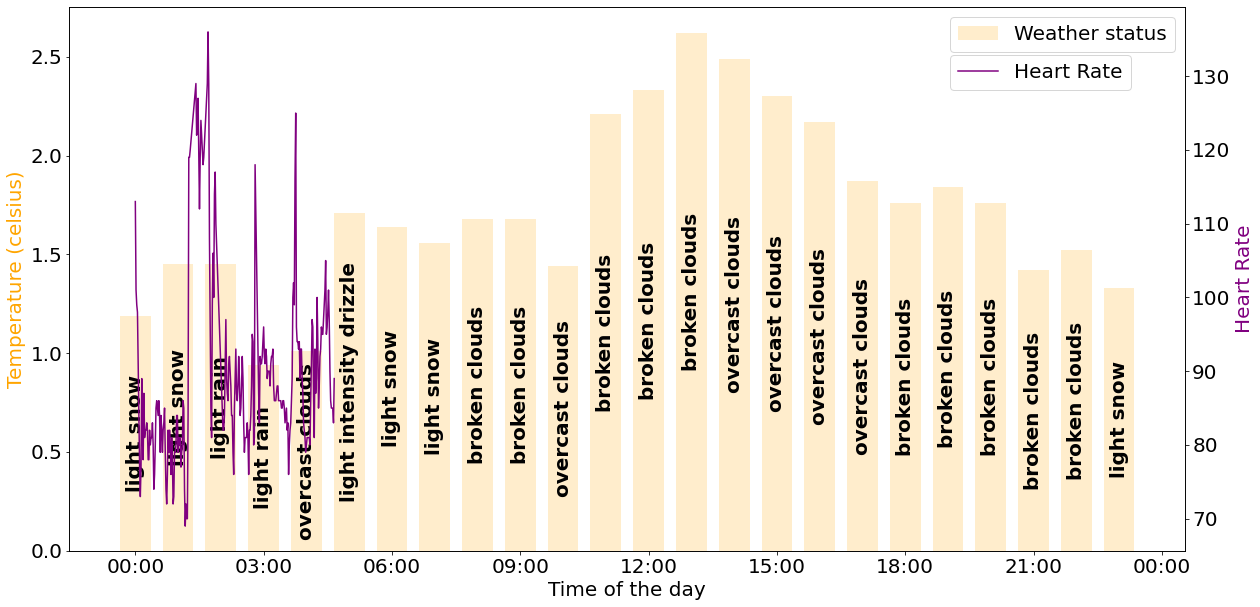

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
ax2=ax.twinx()
############# FIRST LAYER #################
# WEATHER
#Remove the night for purposes of plotting
df_weather_loc = df_weather.copy()
#df_weather_loc = df_weather_loc.drop(range(8))

# Set bar plots style for events
weather = ax.bar(df_weather_loc['time'],
        df_weather_loc['actual_temp'],
        color='orange', width=0.03, alpha=0.2, label='Weather status')
ax.bar_label(weather, labels=df_weather_loc['weather'], label_type='center', rotation=90, weight='bold', fontsize=20)

# Set title, labels for axes and legends
ax.set_xlabel("Time of the day", fontsize=20)
ax.set_ylabel("Temperature (celsius)", color="orange", fontsize=20)
ax.legend(prop={"size":20})
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=8)


############ SECOND LAYER ##################
# HEART RATE
hr = ax2.plot(df_HR['start_time'],
        df_HR['heart_rate'],
        color='purple', label='Heart Rate')

# Set title, labels for axes and legends
ax2.set_ylabel("Heart Rate", color="purple", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=8)
ax2.legend(bbox_to_anchor=(0.96, 0.93), prop={"size":20})

# Format dates as hours:minutes
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)

# Save image
weather_graph_str = str(day) + '_' + str(month) + '_' + str(year) + '_' + 'weather_correlation.png'
weather_path = os.path.join(root_path, weather_graph_str)
plt.savefig(weather_path, transparent=True)

# Store data

In [28]:
# Check for existence of path, if it doesn't exist, create it
Path(root_path).mkdir(parents=True, exist_ok=True)


# Create paths
cal_str = str(day) + '_' + str(month) + '_' + str(year) + '_' + 'calendar.csv'
cal_path = os.path.join(root_path, cal_str)
weather_str = str(day) + '_' + str(month) + '_' + str(year) + '_' + 'weather.csv'
weather_path = os.path.join(root_path, weather_str)
HR_str = str(day) + '_' + str(month) + '_' + str(year) + '_' + 'heart_rate.csv'
HR_path = os.path.join(root_path, HR_str)
SC_str = str(day) + '_' + str(month) + '_' + str(year) + '_' + 'step_count.csv'
SC_path = os.path.join(root_path, SC_str)

# Save files
df_filtered_dates.to_csv(cal_path, index=False)
df_weather.to_csv(weather_path, index=False)
df_HR.to_csv(HR_path, index=False)
df_step_by_day.to_csv(SC_path, index=False)